In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow.models.rnn import rnn    
from tensorflow.models.rnn.rnn_cell import BasicLSTMCell, LSTMCell
from sklearn.preprocessing import normalize
import pandas as pd
import numpy as np
import collections
import cPickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import mpld3
from datetime import datetime, timedelta, date
import time
import socket
import struct

In [2]:
%matplotlib inline

# Enable mpld3 for notebook
mpld3.enable_notebook()

# Timestamp goodness
def timestamp(dataframe):
    timestamps = []
    for row in dataframe.iterrows():
        timestamps.append(time.ctime(row[1][4] - (row[1][3] - row[1][19]) / 1000))
    dataframe['TIMESTAMP'] = timestamps
    return dataframe

In [3]:
np.random.seed(1234)

In [4]:
# Import netflow capture file(s)

flowdata = pd.DataFrame()

cap_files = ["/home/ehenry/code/ml/rnn/capture20110810.binetflow","/home/ehenry/code/ml/rnn/capture20110811.binetflow"]

for f in cap_files:
    frame = pd.read_csv(f, sep=',', header=0)
    flowdata = flowdata.append(frame, ignore_index=True)

# Strip whitespace
flowdata.rename(columns=lambda x: x.strip(), inplace = True)

In [5]:
flowdata.head(n=2)

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/10 09:46:59.607825,1.026539,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0,0,4,276,156,flow=Background-Established-cmpgw-CVUT
1,2011/08/10 09:47:00.634364,1.009595,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0,0,4,276,156,flow=Background-Established-cmpgw-CVUT


In [62]:
subsample_cats = flowdata.loc[:,['Proto', 'SrcAddr', 'Sport', 
                                 'DstAddr', 'Dport']]

In [7]:
subsample_lists = subsample_cats.values.tolist()

In [86]:
reassembled_flows = []
for flow in subsample_lists[0:20]:
    char_flows = []
    for field in flow:
        for char in str(field):
            if char == ".":
                pass
            elif char == "_":
                pass
            else:
                char_flows.append(char)
    reassembled_flows.append(char_flows)

In [87]:
#del ascii_codes
ascii_codes = []
for i in reassembled_flows:
    ascii_flows = []
    for c in i:
        ascii_flows.append(ord(c))
    ascii_codes.append(ascii_flows)
        
ascii_array = np.asarray(ascii_codes)

In [88]:
reshape_test = np.reshape(ascii_array[0][0:32], (-1, np.sqrt(len(ascii_array[0][0:32]))))
np.shape(reshape_long_array)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:48: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result = getattr(asarray(obj), method)(*args, **kwds)


ValueError: total size of new array must be unchanged

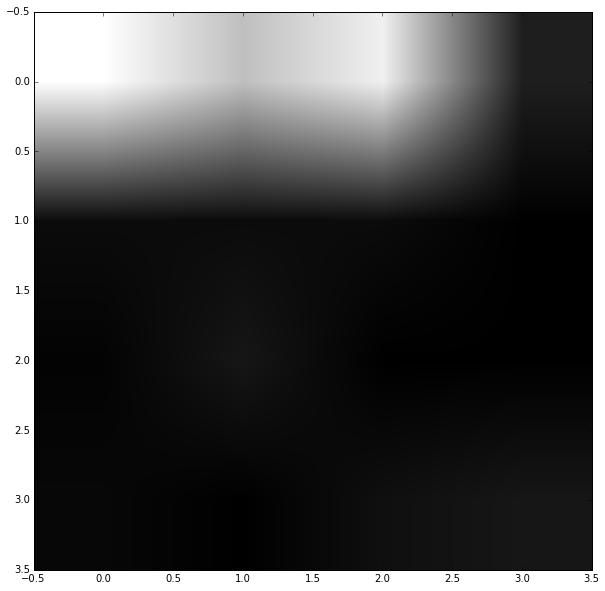

In [84]:
plt.figure(figsize=(10,10))
plt.imshow(reshape_test, cmap='gray', aspect='auto')
plt.show()

SyntaxError: invalid syntax (<ipython-input-19-1f4fca5add4d>, line 4)

In [78]:
def _build_vocab(dataframe):
    lists = dataframe.values.tolist()
    
    strings = []
    for l in lists:
        strings.append(str(l))
    
    counter = collections.Counter(strings)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
    
    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))
    
    return word_to_id

def _flows_to_word_ids(dataframe, word_to_id):
    lists = dataframe.values.tolist()
    
    words = []
    for l in lists:
        words.append(str(l))
    
    return [word_to_id[word] for word in words]

In [79]:
test_vocab = build_vocab(subsample_cats[0:10])

In [85]:
subsample_cats[0:10]

,Proto,SrcAddr,Sport,DstAddr,Dport
0,tcp,94.44.127.113,1577,147.32.84.59,6881
1,tcp,94.44.127.113,1577,147.32.84.59,6881
2,tcp,147.32.86.89,4768,77.75.73.33,80
3,tcp,147.32.86.89,4788,77.75.73.33,80
4,tcp,147.32.86.89,4850,77.75.73.33,80
5,tcp,147.32.86.89,4866,77.75.73.33,80
6,tcp,213.200.244.217,47908,147.32.84.59,6881
7,tcp,75.105.28.60,1419,147.32.84.59,6881
8,tcp,75.105.28.60,1491,147.32.84.59,6881
9,tcp,178.111.79.115,41752,147.32.84.229,13363


In [80]:
test_word_ids = _flows_to_word_ids(subsample_cats[0:10], build_vocab(subsample_cats[0:10]))

In [89]:
lists = []
for row in subsample_cats[0:20].values.tolist():
    lists.append(str(row))
    
lists

["['tcp', '94.44.127.113', '1577', '147.32.84.59', '6881']",
 "['tcp', '94.44.127.113', '1577', '147.32.84.59', '6881']",
 "['tcp', '147.32.86.89', '4768', '77.75.73.33', '80']",
 "['tcp', '147.32.86.89', '4788', '77.75.73.33', '80']",
 "['tcp', '147.32.86.89', '4850', '77.75.73.33', '80']",
 "['tcp', '147.32.86.89', '4866', '77.75.73.33', '80']",
 "['tcp', '213.200.244.217', '47908', '147.32.84.59', '6881']",
 "['tcp', '75.105.28.60', '1419', '147.32.84.59', '6881']",
 "['tcp', '75.105.28.60', '1491', '147.32.84.59', '6881']",
 "['tcp', '178.111.79.115', '41752', '147.32.84.229', '13363']",
 "['tcp', '147.32.84.59', '49185', '147.32.80.7', '80']",
 "['tcp', '75.105.28.60', '1586', '147.32.84.59', '6881']",
 "['tcp', '89.31.40.106', '28451', '147.32.84.59', '6881']",
 "['tcp', '89.31.40.106', '13717', '147.32.84.59', '6881']",
 "['tcp', '188.112.70.72', '1817', '147.32.84.59', '6881']",
 "['tcp', '85.248.56.40', '42480', '147.32.84.59', '6881']",
 "['tcp', '41.188.145.202', '2285', '14